## **COMPUTER VISION - Assignment 2 - HELP GUIDE**

In this help guide, you will learn how to design a Convolutional Neural Network (CNN) model to solve a specific task.  You will have to set up the five stages of  the following list.

1. Access to the image set and labels.
2. Create training, validation, and test subsets, splitting the image set.
3. Model definition: created from scratch or downloaded from a model-zoo.
4. Definition of the optimization algorithm to use (and selection of all the parameters).
5. Definition of the training process: batch policy and loss function.
6. How to carry out Transfer Learning from a pretrained model.

You must go through the notebook reading the explanations within each cell and trying to understand the code. Different image datasets will be used along the guide.

We will use the library released by **fastai** (https://docs.fast.ai/). It provides a high-level API that makes the learning process easier and simpler. An electronic book (https://github.com/fastai/fastbook) and a video course (https://www.fast.ai/posts/2022-07-21-dl-coders-22.html) are two additional available external resources. 

Remember to use hardware acceleration via GPU (Edit - Notebook Configuration - GPU). Otherwise, many of the computations below will be extremely slow. 

In [1]:
import sys
import subprocess
import pkg_resources

required = {'nbdev', 'fastbook'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
print(missing)

if 'nbdev' in missing:
    print("INSTALLING nbdev")
    !pip install nbdev
    #python = sys.executable
    #subprocess.check_call([python, '-m', 'pip', 'install', 'nbdev'], stdout=subprocess.DEVNULL)
!pip list |grep nbdev
if 'fastbook' in missing:
    print("INSTALLING fastbook")
    !pip install -Uqq fastbook
    #python = sys.executable
    #subprocess.check_call([python, 'pip', 'install -Uqq', 'fastbook'], stdout=subprocess.DEVNULL)
!pip list |grep fastbook

{'fastbook', 'nbdev'}
INSTALLING nbdev
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 1.6 MB 53.8 MB/s 
nbdev                         2.3.9
INSTALLING fastbook
     |████████████████████████████████| 719 kB 2.7 MB/s 
     |████████████████████████████████| 1.3 MB 40.2 MB/s 
     |████████████████████████████████| 5.5 MB 43.2 MB/s 
     |████████████████████████████████| 451 kB 15.0 MB/s 
     |████████████████████████████████| 212 kB 18.9 MB/s 
     |████████████████████████████████| 182 kB 48.4 MB/s 
     |████████████████████████████████| 115 kB 56.9 MB/s 
     |████████████████████████████████| 127 kB 63.6 MB/s 
     |████████████████████████████████| 7.6 MB 54.3 MB/s 
fastbook                      0.0.29


In [2]:
# Now we SET UP Fastai
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

MessageError: ignored

## **Function to display evaluation metrics**

In [ ]:
# Function taken from https://github.com/timeseriesAI/tsai (https://forums.fast.ai/t/plotting-metrics-after-learning/69937)
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

## **How to download labeled image datasets from repositories**

Many image datasets are available in .tar format from well-known repositories.  That allows us to download and save them to our local drive using a direct call if needed. However, this process **can be pretty slow**. A better alternative is to allow Colab to save them anywhere and return us the access path. (see examples below using untar_data).

In [ ]:
#!pip install fastdownload # install this package if necessary
# this code save the data in our drive, pretty slow !!!
%cd '/content/gdrive/My Drive'
from fastdownload import FastDownload
base="fastai" # local directory
d = FastDownload(base=base,archive='downloaded', data='extracted')
path=d.get(URLs.MNIST_SAMPLE,force=True)
# check the content in fastai
print(path)

/content/gdrive/My Drive


/content/gdrive/My Drive/fastai/extracted/mnist_sample


## **Create training, validation, and test sets by splitting the image dataset**
The code below shows an example of how to create a data loader object (see https://docs.fast.ai/data.load.html) that takes as input a labeled dataset and generates useful batches for the training process. We use untar_data() to download the tar file. When the dataset is not available as a tarball a different reading process have to be applied. See https://docs.fast.ai/tutorial.datablock.html for many other types of Datablock inputs.  See also https://muttoni.github.io/blog/machine-learning/fastai/2020/12/26/datablocks-vs-dataloaders.html

Each dataset is set-up in a different way. This organization, most of the time, is used to define the item/example/instance label. The code below shows how to create a DataBlock structure from a dataset whose elements are distributed in subdirectories. The item labels are the name of the subdirectory in which they are included.

Setting-up type transforms pipelines
Found 14434 items
2 datasets of sizes 12396,2038
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_sample/train/3/16427.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/mnist_sample/train/3/16427.png
    applying parent_label gives
      3
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(0))


Found 14434 items
2 datasets of sizes 12396,2038
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline:

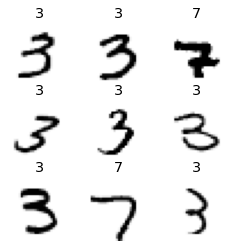

In [ ]:
# Example-1: MNIST
from fastai.data.external import untar_data, URLs 
# Datablock definition from a set of functions
mnistdb = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock), # define the input to the learner
                  get_items = get_image_files,      # read all images in subfolders
                  get_y = parent_label,             # define the labels
                  splitter = GrandparentSplitter()) # generate training and validatiion sets (No existe el test)
                  
# Data load
mnistdl=mnistdb.dataloaders(untar_data(URLs.MNIST_SAMPLE)) 
# dowload tha dataset and use the DataBlock definition to create the training dataset
# 
mnistdl.show_batch(max_n=9, figsize=(4,4)) # shows a batch of images
#
# if something was wrong, this gives us a summary
mnistdb.summary(untar_data(URLs.MNIST_SAMPLE))
#


In [ ]:
# Testing the standard transformations already included by default
test_eq(mnistdb.type_tfms[0], [PILImageBW.create]) # To create a PILImageBW
test_eq(mnistdb.type_tfms[1].map(type), [Categorize]) # to create the labels
test_eq(mnistdb.default_item_tfms.map(type), [ToTensor])# to transform in a tensor
test_eq(mnistdb.default_batch_tfms.map(type), [IntToFloatTensor])# to transform in f
doc(DataBlock) # we access to the DataBlock documentation ans source code.


The code below uses a different dataset and a different way to label items. Now, the Datablock structure uses a labeling function.

/root/.fastai/data/oxford-iiit-pet


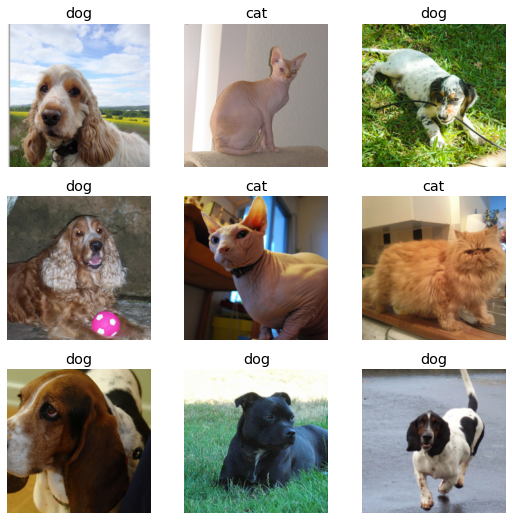

In [ ]:
# Example-2: Dogs and Cats
#
path = untar_data(URLs.PETS)
print(path)  # you realize where the data are saved
def label_func(fname):  # function to create the labels
    return "cat" if fname.name[0].isupper() else "dog"


PETSdb = DataBlock(blocks    = (ImageBlock, CategoryBlock), # define the type of data block
                   get_items = get_image_files, # read all images in subfolders
                   get_y     = label_func, # create the labels
                   splitter  = RandomSplitter(), #split the block for training and test/validation
                   item_tfms = Resize(224)) # resize all images to the same size
 
PETSdl = PETSdb.dataloaders(path/"images") # create the object to propose batches
PETSdl.show_batch() # shows a batch of images

Fastai provides us with different API levels. The code below shows how to use Fastai's VISION API. Now, instead of class DataBlock, we use the class ImageDataLoaders to create the training dataset. Here the splitting in training and validation is already done. In addition, geometrical transformations for items and batches are defined.

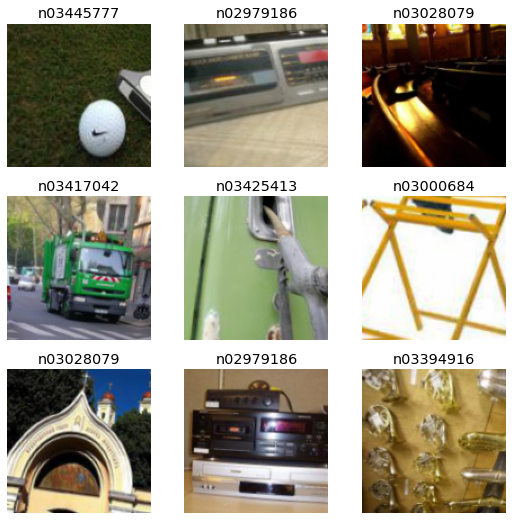

In [ ]:
# Example-3: Imagenette (subset of ImageNet with 10 classes)
# Here we use classes from the VISION API 
# IMAGENETTE use the same file configuration as IMAGENET
path = untar_data(URLs.IMAGENETTE_160) # download the data organized in an imageNet-style format
IMAGENETTEdl = ImageDataLoaders.from_folder(path, valid='val', 
                                  item_tfms=RandomResizedCrop(128, min_scale=0.35), # Crop image patches
                                  batch_tfms=[Normalize.from_stats(*imagenet_stats),*aug_transforms()])  # normalize with the Imagenet  values and applies data augmentation
IMAGENETTEdl.show_batch() # shows a batch of images
doc(ImageDataLoaders)

## **The Learner Object** 
The code below shows an example of how to create the object that defines the learning process. It includes relevant pieces of information such as the model, use of pretrained weights, loss function, metrics, learning rate, and number of iterations/epochs. We use the 1cycle learning rate criteria from Leslie Smith to accelerate convergence in optimization. (https://arxiv.org/abs/1803.09820, https://arxiv.org/abs/1708.07120). A range of values for the learning rate is set by fixing a maximum value. This maximum value is chosen by observing the shape of the lr_find() output curve. 

Besides, you will find the calls to show the final results and training curves.

0.0008317637839354575


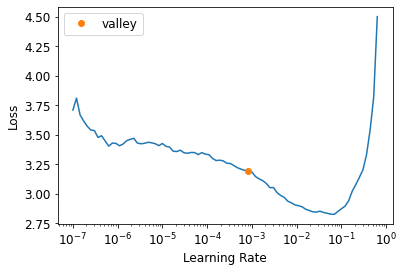

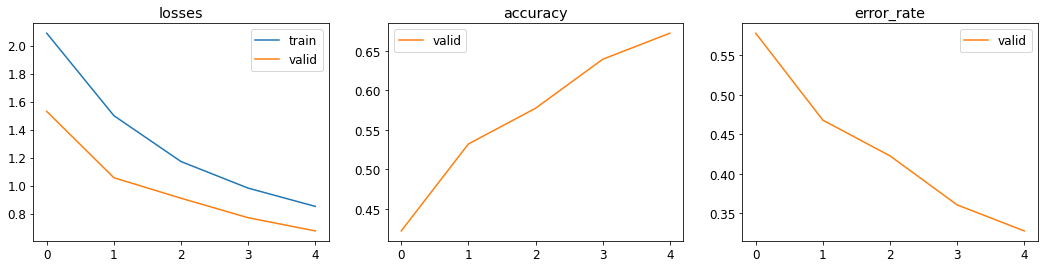

Sequential (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 64 x 64   
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 64 x 64   
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 32 x 32   
MaxPool2d                          

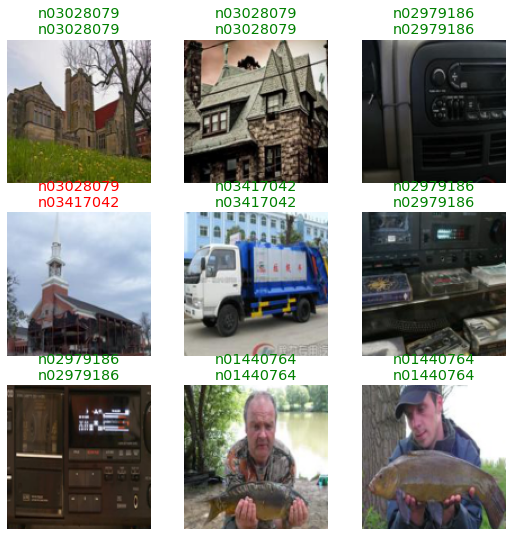

In [ ]:
# Here we use the VISION-API
from fastai.test_utils import *
#
# Example-1: We use "vision_learner" for images
#
dls=IMAGENETTEdl
model=xresnet18
learn = vision_learner(dls, model, metrics=[accuracy,error_rate], loss_func=FocalLossFlat(), pretrained=False) # setting the learning scenario
lr=learn.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(lr[0])
# Recomendable estudiar el learning rate en dos valores más, uno por encima y otro por debajo del aportado por lr_find

learn.fit_one_cycle(n_epoch=5, lr_max=lr[0]) # running the optimizer one-cycle
learn.recorder.plot_metrics() # shows accuracy curve along epochs
learn.show_results()
learn.summary() # show all details

We can use the fastai's GENERAL API as an alternative to the VISION API. In this case, we instance the general Learner class.

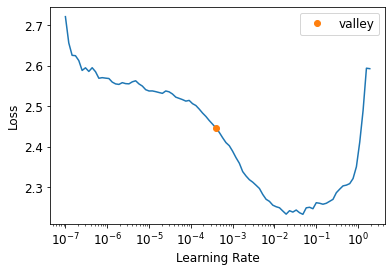

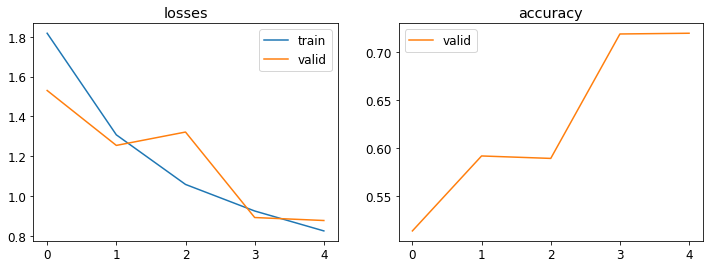

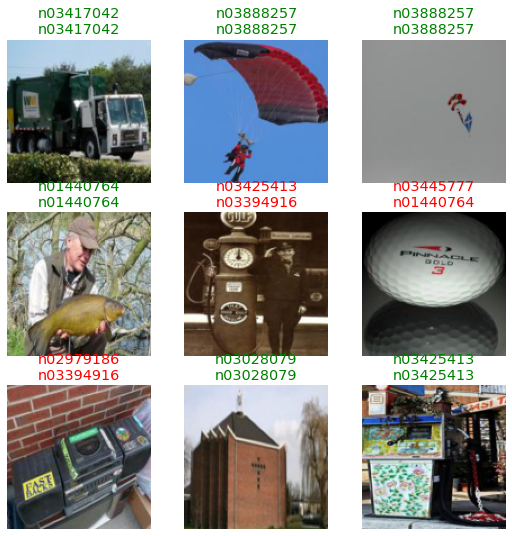

In [ ]:
# Example-2 we use the general Learned class

learn = Learner(IMAGENETTEdl, xresnet34(n_out=10), metrics=accuracy) # no pretrained model
lr=learn.lr_find() # find the maximum value for lr to use in the next call to the optimizer
learn.fit_one_cycle(n_epoch=5, lr_max=lr[0])
learn.recorder.plot_metrics()
learn.show_results()
doc(Learner)

## **How to test a model**

In [ ]:
#Useful references for testing in fastai:
# https://muellerzr.github.io/fastblog/2020/08/10/testdl.html 
# https://benjaminwarner.dev/2021/10/01/inference-with-fastai

# We employ IMAGENETTE_160 for this example
source = untar_data(URLs.IMAGENETTE_160)

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_items=get_image_files, 
                   get_y=parent_label,
                   item_tfms=[RandomResizedCrop(192, min_scale=0.35), 
                              FlipItem(0.5)],
                   batch_tfms=Normalize.from_stats(*imagenet_stats))

dls = dblock.dataloaders(source)

learn = Learner(dls, xresnet50(n_out=dls.c), opt_func=ranger, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                metrics=accuracy)

learn.fit_one_cycle(2)

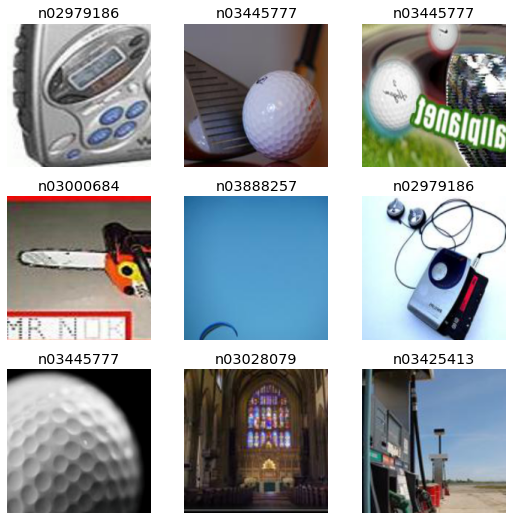

In [ ]:
dls.train.show_batch()

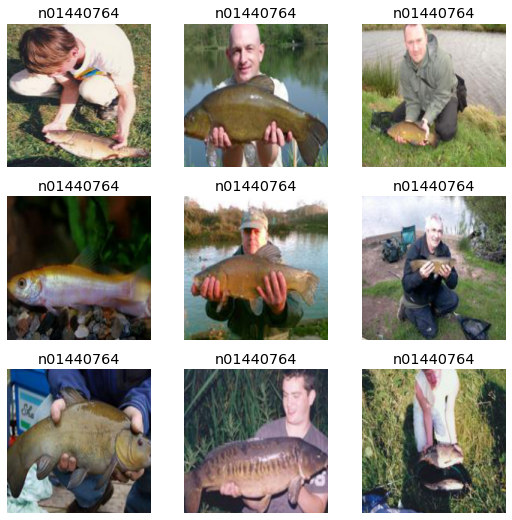

In [ ]:
dls.valid.show_batch()

In [ ]:
test_files = [fn for fn in sorted((source/'val').glob('**/*')) if fn.is_file()]

test_dl = learn.dls.test_dl(test_files,with_labels=True)

In [ ]:
# We perform prediction on this bunch of data (in this case, the validation set)
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
# We compute accuracy
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

The test accuracy is :  64.7643 %


Number of test examples: 3925


Test Accuracy
64.76433121019109


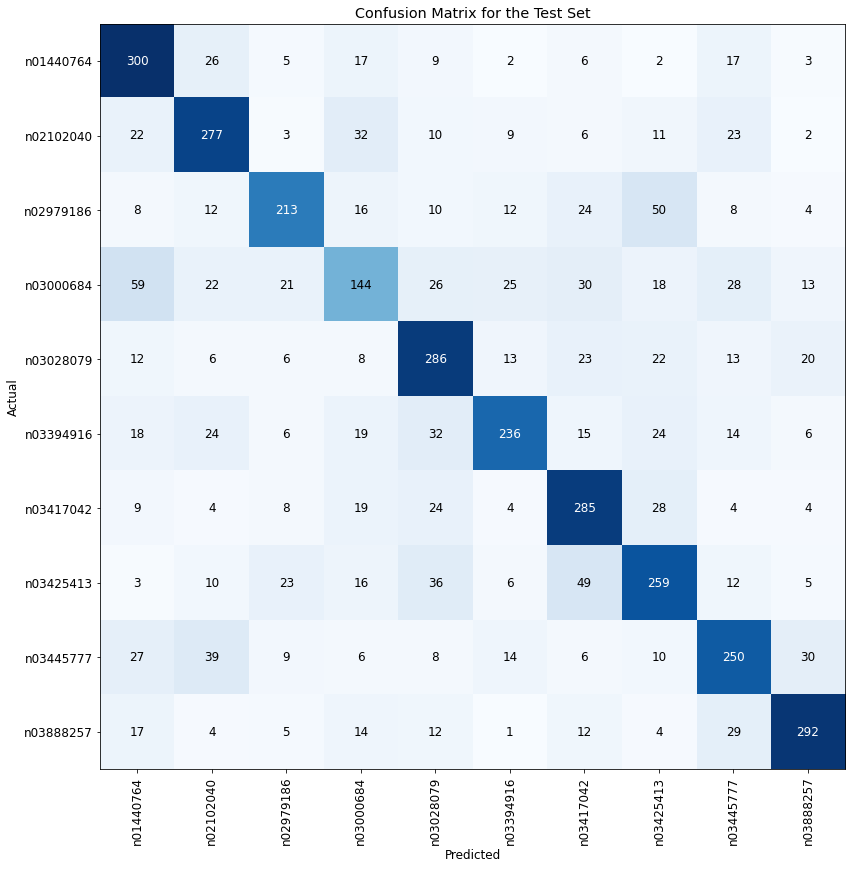

In [ ]:
# We compute the confusion matrix
interp = ClassificationInterpretation.from_learner(learn, 1, test_dl)
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy') 
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

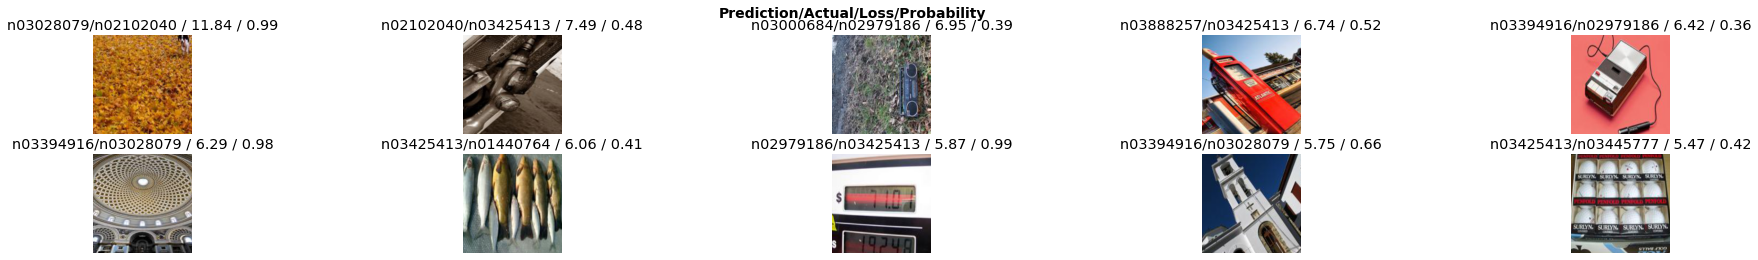

In [ ]:
# we display the n classes with higher confusion level
interp.plot_top_losses(10, nrows=2, figsize=(32,4))

## **The Optimizer Object**

Fastai uses an Optimizer Class that includes most optimizers in PyTorch (see https://docs.fast.ai/examples/migrating_pytorch_verbose.html). The code below shows an example of how to define a fastai optimizer function using a specific optimizer, i.e. Adam. You only have to define a **partial function** with **OptimWrapper** indicating the PyTorch optimizer you want to use. 

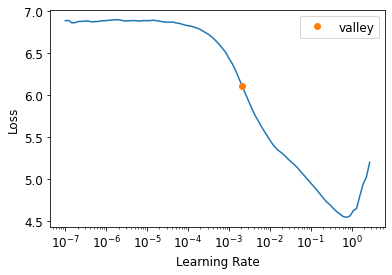

In [ ]:
# See https://docs.fast.ai/losses.html for all loss-function availables 
from fastai.optimizer import OptimWrapper

from torch import optim
from functools import partial

Adam = partial(OptimWrapper, opt=optim.Adam) # OptimWrapper class wraps Pytorch optimizer for training
# to use the optimizar from torch use torch.optim.Adam
learn = Learner(dls, xresnet18(), metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),  #new loss-function
                opt_func=Adam)

print(f'Optimizer values:{learn.opt.hypers[0]}')
learn.lr_find() # find the lr value and thank to the wrapper fastai schedule the beta0 of AdamW

**Fastai's CALLBACKS:** Callback functions are Fastai's design to add any new resource to your code, https://docs.fast.ai/callback.core.html. Here we show an example of use for three different actions: save the best model, show the training curves after each epoch, and EarlyStopping policy.

In [ ]:
# These callback functions are already defined in Fastai
cbs=[SaveModelCallback(), ShowGraphCallback(),EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn.fit_one_cycle(n_epoch=25, lr_max=1.0e-3,cbs=cbs) # one-cycle uses Adam by default

## **How to create a CNN model from scratch**

The code below shows how to create an instance of a sequential model and how to visualize a summary of it. In this first example the sizes of the tensors are fixed.

In [ ]:
# LET'S START CHECKING THE SIZE OF A TENSOR
data,label=IMAGENETTEdl.one_batch()
print(f'tensor data size{data.shape}','label data size{label.shape}')
print(f'This means a tensor of {data.shape[0]} items, where each item has {data.shape[1]} channels of size [{data.shape[2]},{data.shape[3]}]')

tensor data sizetorch.Size([64, 3, 128, 128]) label data size{label.shape}
This means a tensor of 64 items, where each item has 3 channels of size [128,128]


Flatten is a class that serves to simplify the coding. In the Net1 class, all the layers parameters are fixed, but that it is not necessary or compulsory. The General Construction shows how to pass parameters to the layers definition.

In [ ]:
# The simplest way
#
from torch import nn
import torch.nn.functional as F

Net1=nn.Sequential(
    nn.Conv2d(1, 32, 3, 1), nn.ReLU(), 
    nn.Conv2d(32, 64, 3, 1), 
    # A head to the model
    nn.MaxPool2d(2), nn.Dropout2d(0.25),
    nn.Flatten(), nn.Linear(9216, 128), nn.ReLU(),
    nn.Dropout2d(0.5), nn.Linear(128, 10), nn.LogSoftmax(dim=1)
)
total_params(Net1)

(1199882, True)

In [ ]:
# A better approach by using classes

from torch import nn
import torch.nn.functional as F
from fastai.test_utils import *

# this class help us to transform a 3D tensor into an 1D one.
class Flatten(nn.Module):
    "Flattens an input"
    def forward(self, x): return x.view(x.size(0), -1)
#
# In this example the layers are defined as instances of the Pytorch nn package.
# For this reason are defined inside of the super.__init() call.
class Net1(nn.Sequential):
  # IT IS KEY HERE TO SET LAYERS SIZES MATCHING THE SPATIAL SIZE OF THE INPUT TENSOR
  # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, 
  #          groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)  
    def __init__(self):
        super().__init__(
            nn.Conv2d(1, 32, 3, 1), nn.ReLU(), 
            nn.Conv2d(32, 64, 3, 1), 
            # A head to the model
            nn.MaxPool2d(2), nn.Dropout2d(0.25),
            Flatten(), nn.Linear(9216, 128), nn.ReLU(),
            nn.Dropout2d(0.5), nn.Linear(128, 10), nn.LogSoftmax(dim=1)
        )
model=Net1() # object instantiation
total_params(model) # CHECK the number of parameters and if it’s trainable or not

(1199882, True)

##**General construction of a model**

The code below shows a general approach to define a model. A model is considered as a composition of computing blocks. A class is defined for each computing block.  Here, each class can be fed with several arguments. Don't pay attention to the meaning of the arguments.

Each class is composed of two basic functions: **\__init\__** (definitions) and **forward** (computing).

Using this approach, we can design no-sequential models, which means any model defined by an acyclic direct graph.

In [ ]:
from torch import nn
from torch.nn import functional as F

# This class computes convolution+relu+MaxPool2D
class BasicBlock(nn.Module): # block definition
  def __init__(self, channels,kernel_size,padding,groups):
    super(BasicBlock,self).__init__() 
    # layers definition
    self.conv=nn.Conv2d(channels[0],channels[1],kernel_size=kernel_size,
                        padding=padding, groups=groups)
    self.actv=nn.ReLU()
    self.pool=nn.MaxPool2d(2)
   
  def forward(self,x):  # computing sequence of layers
      x=self.conv(x)
      x=self.actv(x)
      x=self.pool(x)
      return  x

#This class computes the head(linear+relu+dropout)
class BasicHead(nn.Module): # block definition
    def __init__(self,channels,dropout):
      super(BasicHead,self).__init__()
      # layers definition
      self.lin=nn.Linear(channels[0],channels[1])
      self.actv=nn.ReLU()
      self.dropout=nn.Dropout(dropout)
      
    def forward(self,x): # computing sequence of layers
        return self.dropout(self.actv(self.lin(x)))

# this class computes the training loss function (Softmax or Linear)
class BasicLoss(nn.Module): # block definition
      def __init__(self,channels, flagLoss):
          super(BasicLoss,self).__init__()
          # layers definition
          if flagLoss=="SoftMax":
              self.Loss=nn.Softmax(dim=-1)
          else:
              self.Loss=nn.Linear(channels,1)
              
      def forward(self,x): # computing sequence of layers
          return self.Loss(x)

#This class computes a sequential model
class SimpleModel(nn.Module):  # model definition
    def __init__(self,seq_channels,padding,dropout,loss,kernel_size):
        super(SimpleModel,self).__init__()
        # blocks definition
        # Block-1
        self.bblock1=BasicBlock(seq_channels[0:2],kernel_size,padding,groups=1)
        # Block-2
        self.bblock2=BasicBlock(seq_channels[1:3],kernel_size,padding,groups=1)
        # Block-3
        self.bhead1=BasicHead(seq_channels[3:5], dropout)
        self.bhead2=BasicHead(seq_channels[4:6], dropout)
        # Block-4
        self.bout=BasicLoss(seq_channels[5],loss)
        
    def forward(self,x): # computing sequence of blocks
        x=self.bblock1(x)
        x=self.bblock2(x)
        x=x.view(x.shape[0],-1) # FLATTEN
        x=self.bhead1(x)
        x=self.bhead2(x) 
        return self.bout(x)

# This class allows to mix the tensors from different models
class FullModel(nn.Module): # definition
    def __init__(self, seq_channels,padding,dropout,loss,device,kernel_size):
        super(FullModel,self).__init__()
        # Scale
        self.sc1=SimpleModel(seq_channels,padding,dropout,loss,kernel_size)
    
    def forward(self,x):
        return self.sc1(x)

## **Metrics in multilabel classification**

Below you can find some examples of the use of multi-label metrics. Specifically, those defined for the binary case (F1). We also show the prediction of new items and the display of the worst items in training.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


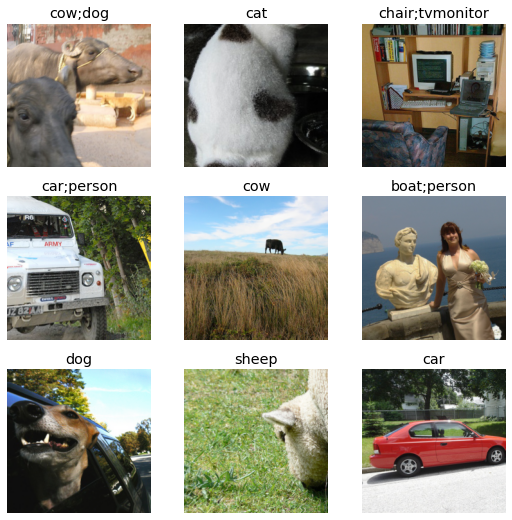

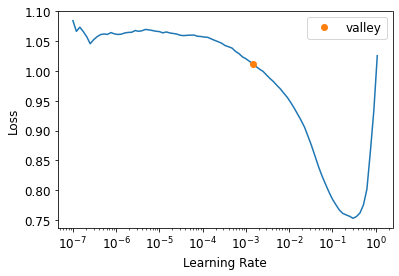

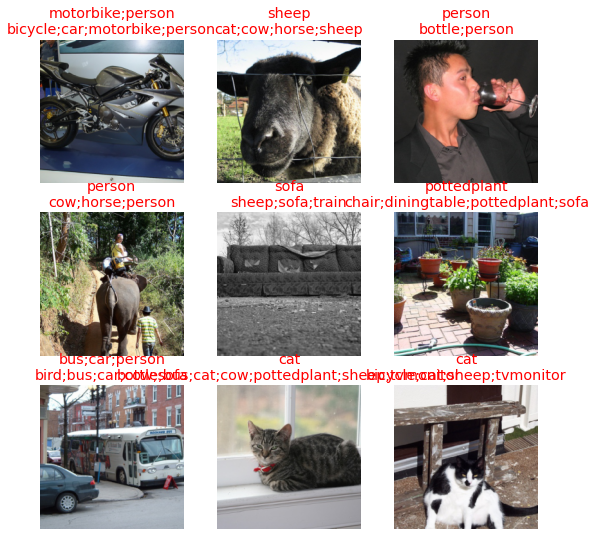

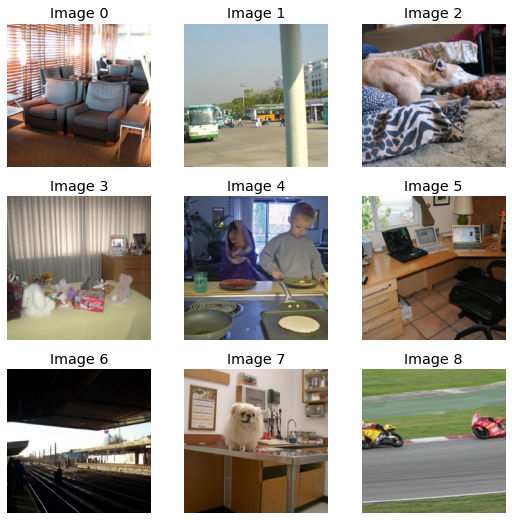

In [ ]:
# Example-1
from fastai.data.external import untar_data, URLs
import pandas as pd
from fastai.vision.all import *

path = untar_data(URLs.PASCAL_2007)
path.ls()
df = pd.read_csv(path/'train.csv')
df.head()
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))
dls.show_batch()
#
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5),f1_macro,f1_samples])
lr=learn.lr_find()
learn.fine_tune(2, lr[0])
learn.show_results()
# Showing the training improvement
#
learn.predict(path/'train/000005.jpg') # sample prediction
#
# Now we  check where the model did its worse
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


((#5) ['chair','diningtable','horse','sofa','tvmonitor'],
 TensorBase([False, False, False, False, False, False, False, False,  True, False,  True, False,  True, False, False, False, False,  True, False,  True]),
 TensorBase([0.1185, 0.3066, 0.4929, 0.4900, 0.4733, 0.3166, 0.0628, 0.1543, 0.9997, 0.3384, 0.9841, 0.2415, 0.6103, 0.4958, 0.3327, 0.4467, 0.3789, 0.8873, 0.3445, 0.8660]))

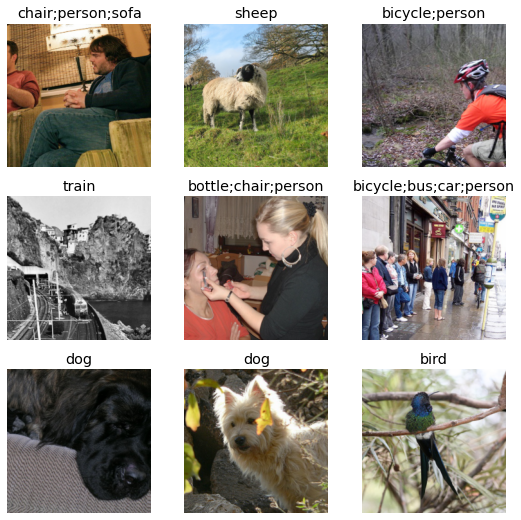

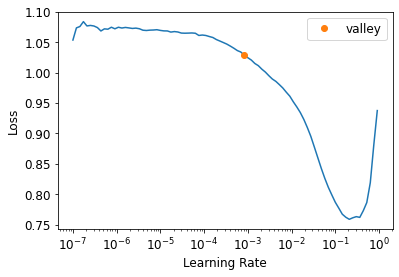

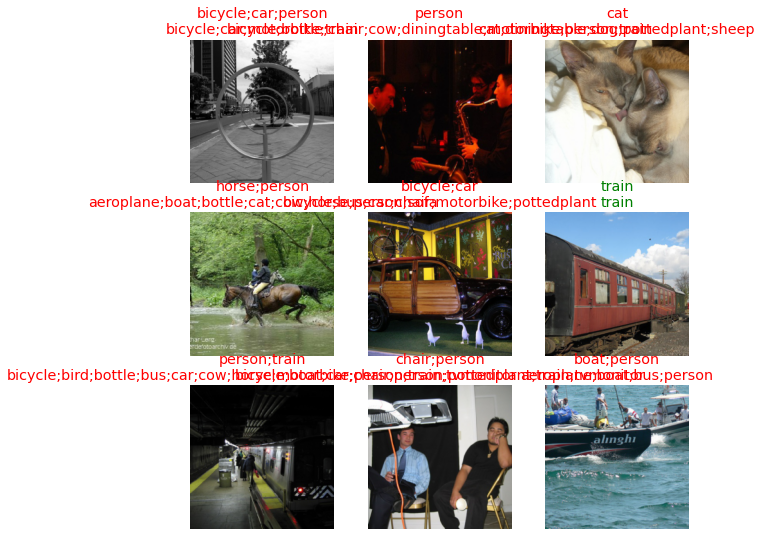

In [ ]:
# Example-2: With the data block API
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('fname', pref=str(path/'train') + os.path.sep),
                   get_y=ColReader('labels', label_delim=' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))
dls = pascal.dataloaders(df)
dls.show_batch(max_n=9)
#
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples]) # it uses accuracy_multi from PyTorch
lr=learn.lr_find()
learn.fine_tune(2, lr[0])
learn.show_results()
#
learn.predict(path/'train/000005.jpg') # sample prediction
#
# Now we  check where the model did its worse


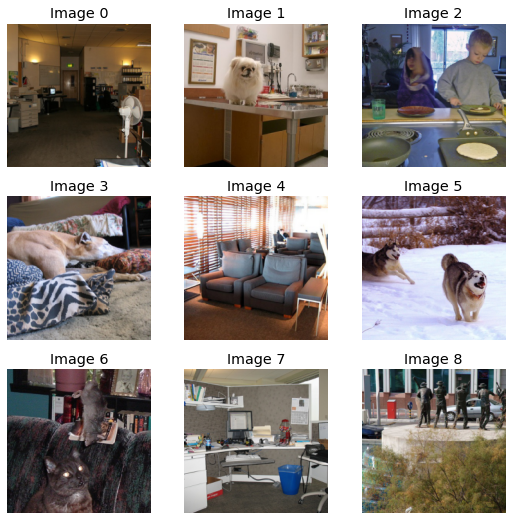

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

## **Transfer learning: how to fine-tune a pretrained model**

Here we learn how to change a pre-trained model by cutting its head, adding a new head, and fine-tuning the new model. Lets's start with a simple example.

In [ ]:
from fastai.vision.all import *
# m is the model
m = nn.Sequential(nn.Conv2d(2,3,1), nn.MaxPool3d(5), nn.AdaptiveAvgPool2d(5), nn.Linear(2,3))
assert has_pool_type(m)  # here we identify where is a pooling layer
test_eq([has_pool_type(m_) for m_ in m.children()], [False,True,True,False])
body = create_body(m) # cut everything from the last Pooling layer (included)
test_eq(len(body), 2)
test_eq([has_pool_type(m_) for m_ in body.children()], [False,True])
#
m = create_body(m, cut=3) # alternatively, we can cut indicating the number of layer
test_eq(len(m), 3)
#
# now let's learn how to add a new head
#
# In fastai, the model head takes nf features, runs through lin_ftrs, and out n_out classes.
# 
# create_head (nf, n_out, lin_ftrs=None, ps=0.5, pool=True,
#              concat_pool=True, first_bn=True, bn_final=False,
#              lin_first=False, y_range=None)
#
# In this example you learn how to add a new head set by fastai
# The default call transforms the input in 512 features and then in n_out features
tst=create_head(10,10)  # equivalent to tst=create_head(10,10,[512])
tst

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=20, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

This example below shows a  model resnet18 downloaded, the original head cuts and added a new one (Fastai standard) according to the output units. n_in defines the number of input channels.

In [ ]:
tst = create_vision_model(models.resnet18, 10, True, n_in=3)
tst


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

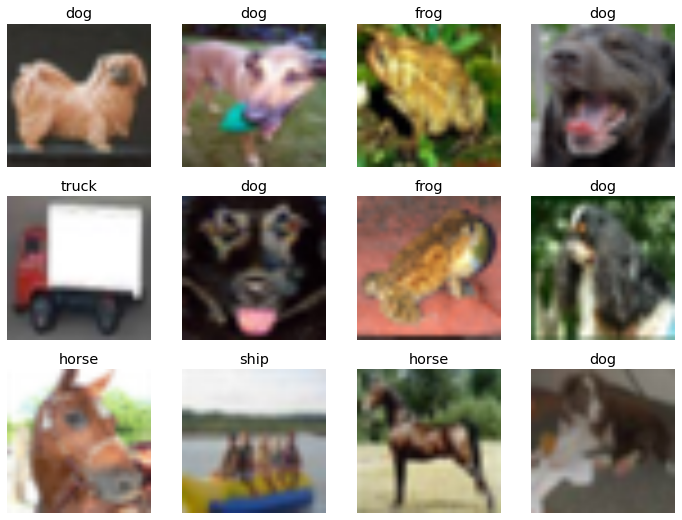

In [ ]:
path = untar_data(URLs.CIFAR)
CIFAR10 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42), #10% of the training set will be used for validation
    get_y=parent_label,
    item_tfms = Resize(224), # so our images have the same size as ImageNet images (the dataset in which ResNet18 was pretrained on)
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)] # Normalize data with ImageNet stats
)

dls = CIFAR10.dataloaders(path,batch_size=128) 

dls.show_batch(max_n=12)

In [ ]:
learn = Learner(dls,tst, metrics=accuracy)
learn.fine_tune(3)

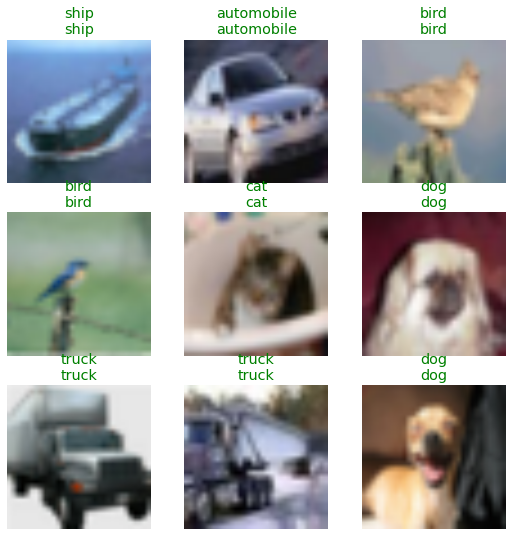

In [ ]:
learn.show_results()

## Final remarks

**How to add my own head or add new layers**. To do this you have to define a new class with your definition (see the technique described in "General construction of a model") and pass it to create_vision_model() using the custom_head attribute.

deepcopy: it means a copy of the argument and all objects included in it.





**How to freeze the gradient in training**: Learner.freeze() or Learner.freeze_to(n) are the call to stop gradient parameters adaptation. However, BatchNormalization parameteres are always adapted by default, train_bn=False must be used inside the Learner definition to stop adaptation: 

**learn1 = vision_learner(deepcopy(dls), resnet18, pretrained=True, train_bn=False**)  